# Experiments

#### Imports:

In [1]:
import os
import sys
import math
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#### Constants:

In [2]:
CSV_PATH = "complete-frame.csv"

#### Aux functions:

In [22]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x.iloc[0:train_cnt].values
    y_train = train_y.iloc[0:train_cnt].values
    x_test = train_x.iloc[train_cnt:]
    y_test = train_y.iloc[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test.iloc[0:train_cnt].values
    y_validate = y_test.iloc[0:train_cnt].values
    x_test = x_test.iloc[train_cnt:].values
    y_test = y_test.iloc[train_cnt:].values

    return x_train, y_train, x_test, y_test, x_validate, y_validate


def plot_graphs(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

#### Load data:

In [27]:
def load_frame():
    frame = pd.read_csv(CSV_PATH, sep=",")
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame

def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_meaningful_subset_2(frame):
    columns = [frame.line_coverage, frame.isAssertionRoulette, frame.isMysteryGuest,
       frame.isResourceOptimism, frame.isForTestersOnly, frame.COH_prod, frame.BUSWEIMER_prod,
       frame.BUSWEIMER_test, frame.csm_LM, frame.prod_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)




def load_all_data(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

#### Data Manipulations:

In [24]:
def median(data_x, data_y, frame):
    labels = [1,2]
    bins = [0,frame.mutation.median(),1]
    frame['mutation_bins'] = pd.cut(frame.mutation, bins=bins, labels = labels, include_lowest=True)
    data_y = pd.concat([frame.mutation_bins], axis = 1)
    return split_data(data_x, data_y)

## Experiment #1: Effective Vs. Non Effective
    - 2 classes: effective tests and non-effective tests:
        - Effective > median(mutation_score)
        - Non Effective < media(mutation_score)

Model Accuracy: 0.7044199109077454


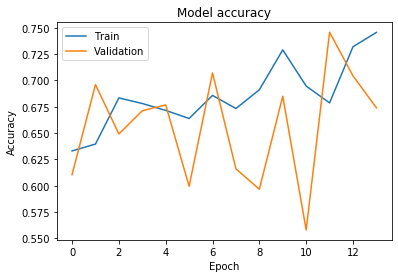

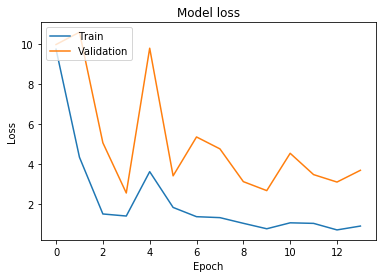

Overfit checks:
Model Accuracy: 0.7178423404693604


In [6]:
frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = median(data_x, data_y, frame)

model = keras.Sequential()

model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])

silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

## Experiment #2: Predicting Mutation Score
    - 11 categories of mutation score: from 0, 0.1, 0.2, .... 1
    - The goal: predict the mutation score

(1687, 24)
---------------- Round #0 ----------------
Model Accuracy: 0.21823205053806305


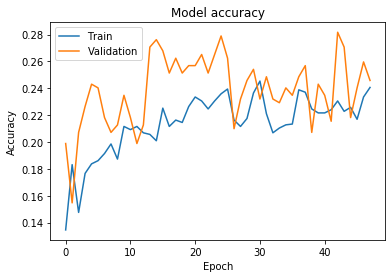

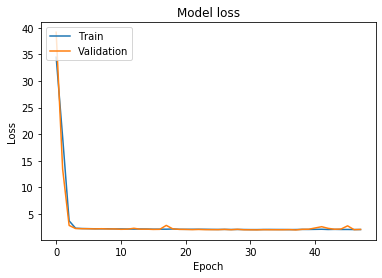

Overfit checks:
Model Accuracy: 0.250148206949234
---------------- Round #1 ----------------
Model Accuracy: 0.28729280829429626


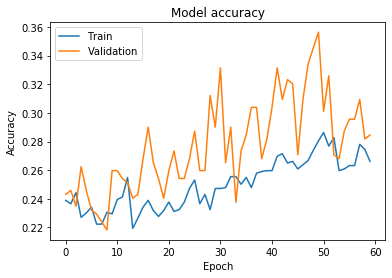

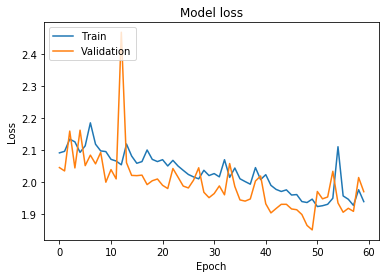

Overfit checks:
Model Accuracy: 0.3046828806400299
---------------- Round #2 ----------------
Model Accuracy: 0.26243093609809875


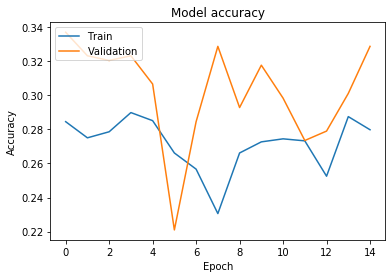

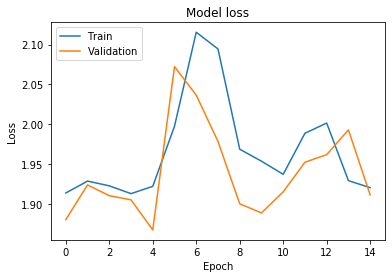

Overfit checks:
Model Accuracy: 0.25548312067985535
---------------- Round #3 ----------------
Model Accuracy: 0.26243093609809875


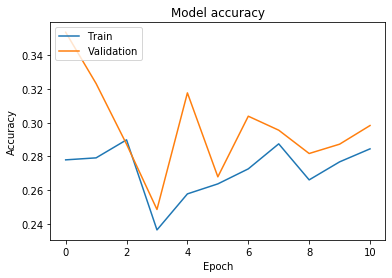

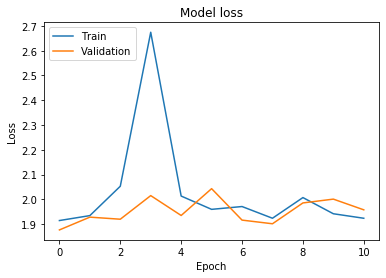

Overfit checks:
Model Accuracy: 0.2987551987171173
---------------- Round #4 ----------------
Model Accuracy: 0.2790055274963379


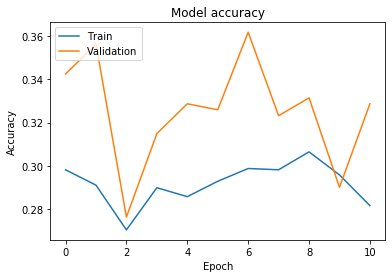

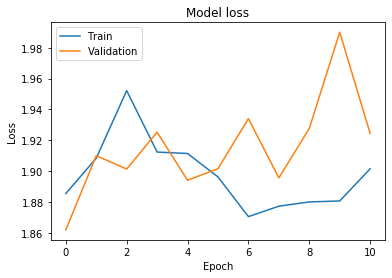

Overfit checks:
Model Accuracy: 0.2975696623325348
---------------- Round #5 ----------------
Model Accuracy: 0.2734806537628174


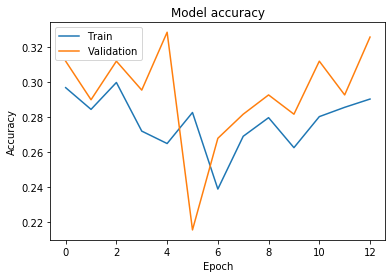

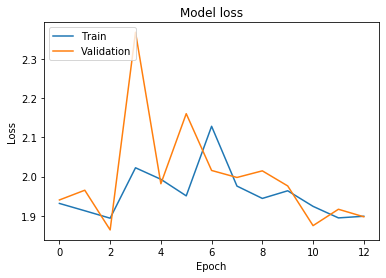

Overfit checks:
Model Accuracy: 0.2916419804096222
---------------- Round #6 ----------------
Model Accuracy: 0.28729280829429626


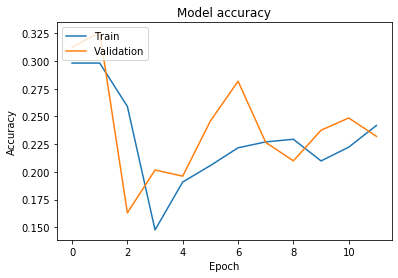

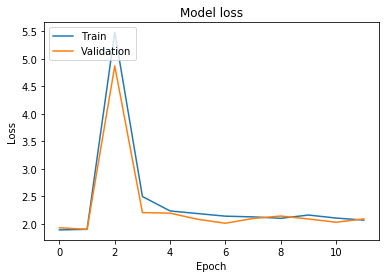

Overfit checks:
Model Accuracy: 0.311796098947525
---------------- Round #7 ----------------
Model Accuracy: 0.2734806537628174


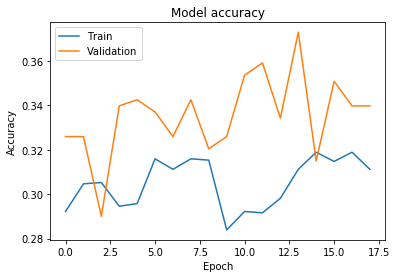

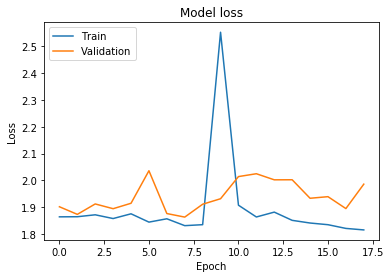

Overfit checks:
Model Accuracy: 0.31890931725502014
---------------- Round #8 ----------------
Model Accuracy: 0.2513812184333801


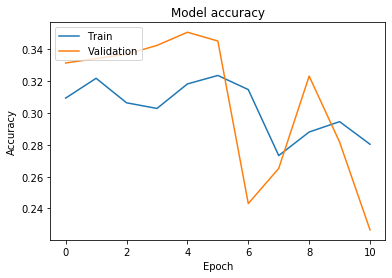

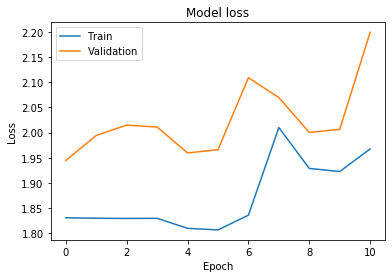

Overfit checks:
Model Accuracy: 0.3242442309856415
---------------- Round #9 ----------------
Model Accuracy: 0.2403314858675003


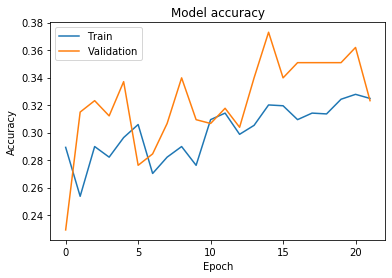

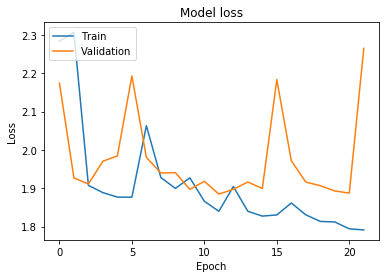

Overfit checks:
Model Accuracy: 0.3295791447162628


In [21]:
frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(1).mul(10)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

for i in range(0,10):
    print("---------------- Round #{} ----------------".format(i))

    history = model.fit(x_train, y_train, epochs=1000, verbose=0,
              validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])
    silent_evaluation(model, x_test, y_test)
    plot_graphs(history)
    print("Overfit checks:")
    silent_evaluation(model, x_train, y_train)

## Experiment 3: 1st and 4th quartile
    - 2 categories
    - The goal: predict the mutation score

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(843, 68)
---------------- Round #0 ----------------
Model Accuracy: 0.8729282021522522


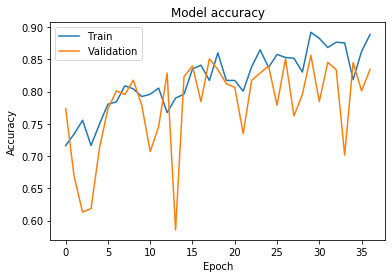

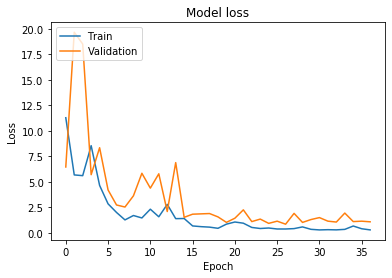

Overfit checks:
Model Accuracy: 0.8908659815788269
---------------- Round #1 ----------------
Model Accuracy: 0.8176795840263367


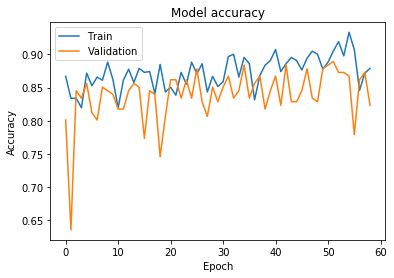

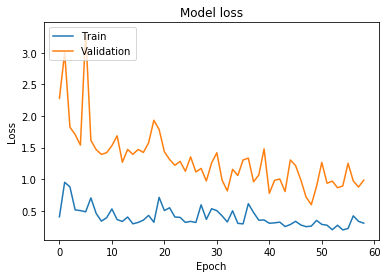

Overfit checks:
Model Accuracy: 0.8730723857879639
---------------- Round #2 ----------------
Model Accuracy: 0.8839778900146484


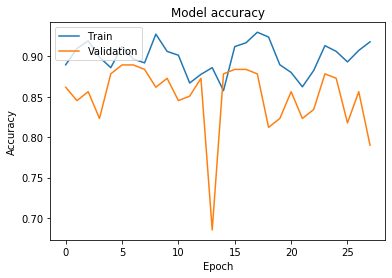

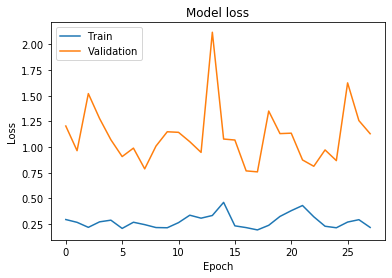

Overfit checks:
Model Accuracy: 0.9371293187141418
---------------- Round #3 ----------------
Model Accuracy: 0.8839778900146484


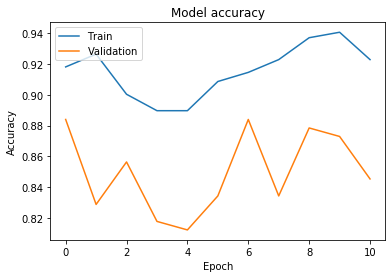

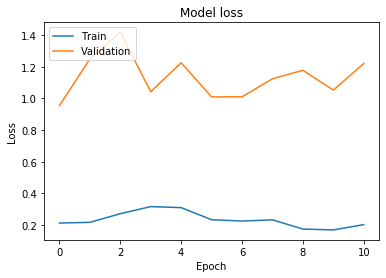

Overfit checks:
Model Accuracy: 0.9395017623901367
---------------- Round #4 ----------------
Model Accuracy: 0.8508287072181702


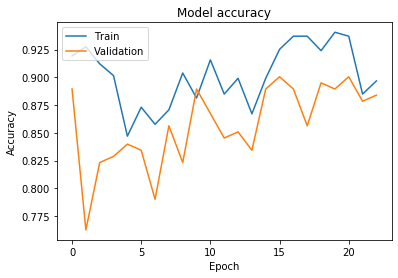

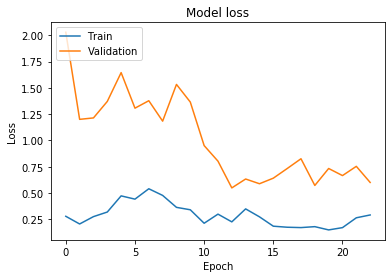

Overfit checks:
Model Accuracy: 0.8825622797012329
---------------- Round #5 ----------------
Model Accuracy: 0.8729282021522522


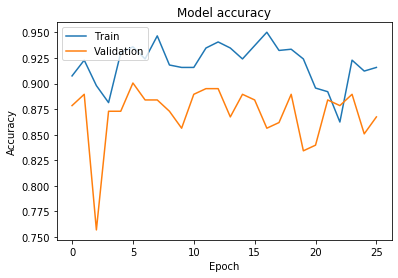

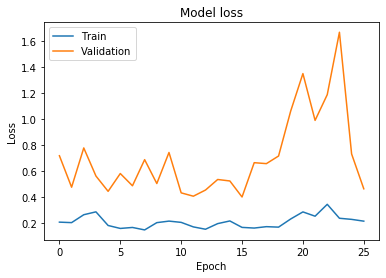

Overfit checks:
Model Accuracy: 0.9454329609870911
---------------- Round #6 ----------------
Model Accuracy: 0.8674033284187317


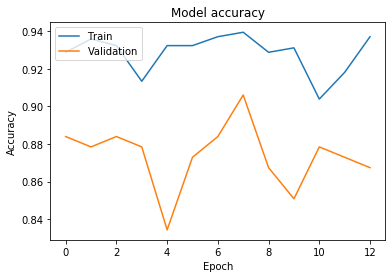

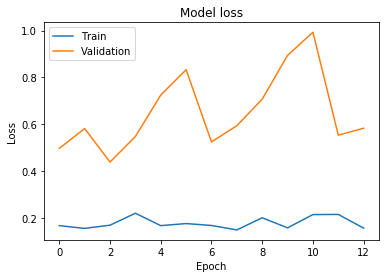

Overfit checks:
Model Accuracy: 0.9442467093467712
---------------- Round #7 ----------------
Model Accuracy: 0.8950276374816895


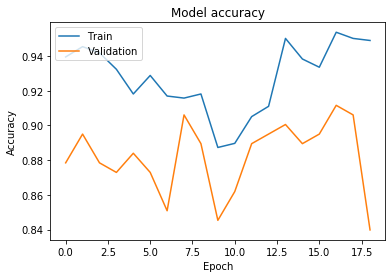

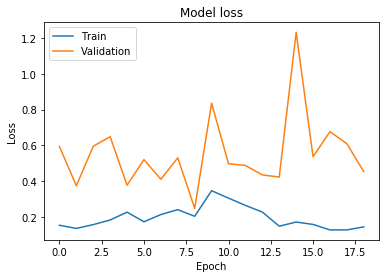

Overfit checks:
Model Accuracy: 0.9466192126274109
---------------- Round #8 ----------------
Model Accuracy: 0.8839778900146484


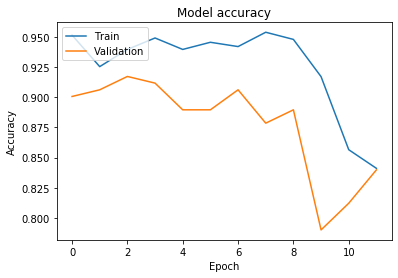

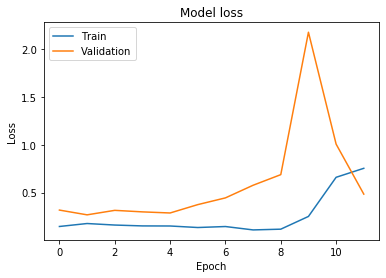

Overfit checks:
Model Accuracy: 0.9572953581809998
---------------- Round #9 ----------------
Model Accuracy: 0.8950276374816895


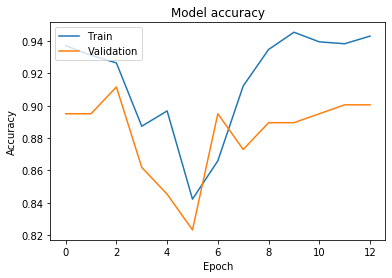

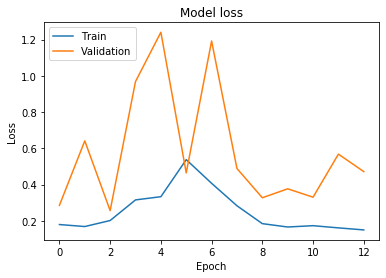

Overfit checks:
Model Accuracy: 0.9537366628646851


In [8]:
frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_all_data(frame) #load_meaningful_subset(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data__y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

for i in range(0,10):
    print("---------------- Round #{} ----------------".format(i))

    history = model.fit(x_train, y_train, epochs=1000, verbose=0,
              validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])
    silent_evaluation(model, x_test, y_test)
    plot_graphs(history)
    print("Overfit checks:")
    silent_evaluation(model, x_train, y_train)

## Experiment #4: All data
    - 2 categories
    - The goal: predict the mutation score

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(843, 25)
---------------- Round #0 ----------------
Model Accuracy: 0.7513812184333801


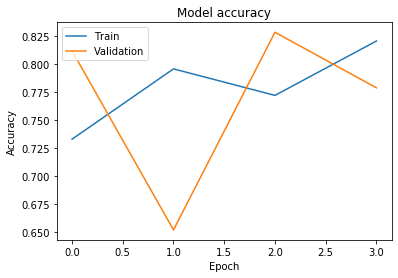

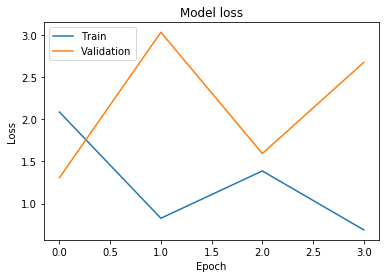

Overfit checks:
Model Accuracy: 0.7841044068336487
---------------- Round #1 ----------------
Model Accuracy: 0.8121547102928162


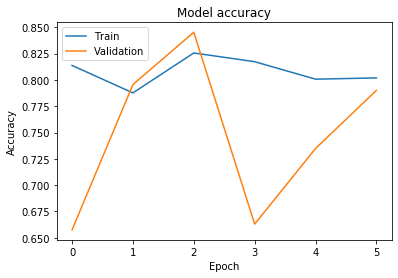

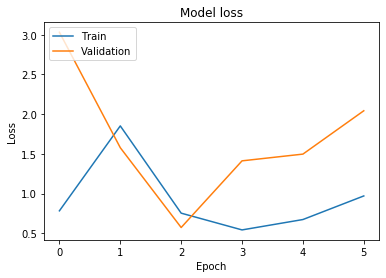

Overfit checks:
Model Accuracy: 0.8410438895225525
---------------- Round #2 ----------------
Model Accuracy: 0.8453038930892944


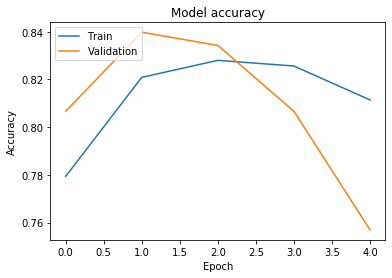

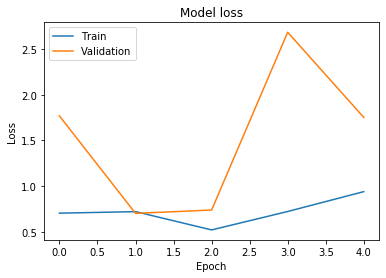

Overfit checks:
Model Accuracy: 0.8517200350761414
---------------- Round #3 ----------------
Model Accuracy: 0.7955800890922546


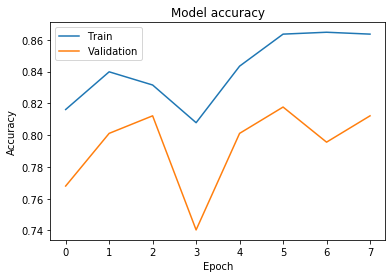

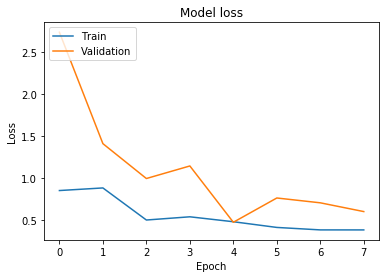

Overfit checks:
Model Accuracy: 0.871886134147644
---------------- Round #4 ----------------
Model Accuracy: 0.8342541456222534


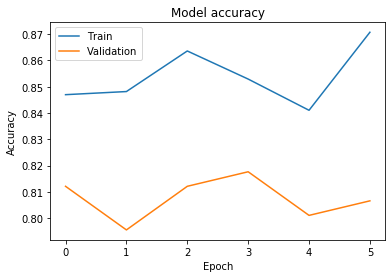

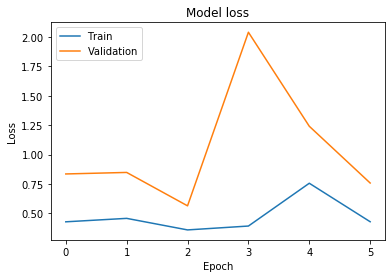

Overfit checks:
Model Accuracy: 0.8730723857879639
---------------- Round #5 ----------------
Model Accuracy: 0.8232043981552124


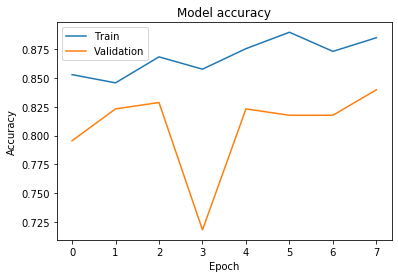

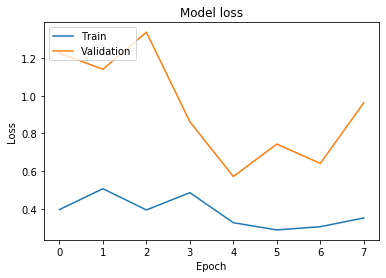

Overfit checks:
Model Accuracy: 0.8849347829818726
---------------- Round #6 ----------------
Model Accuracy: 0.8342541456222534


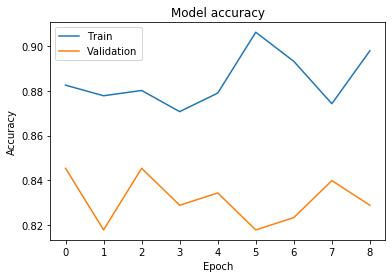

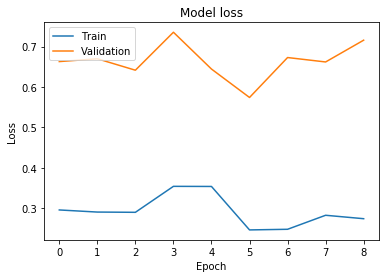

Overfit checks:
Model Accuracy: 0.8908659815788269
---------------- Round #7 ----------------
Model Accuracy: 0.8121547102928162


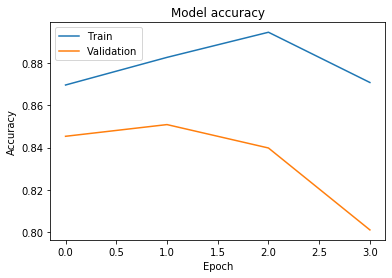

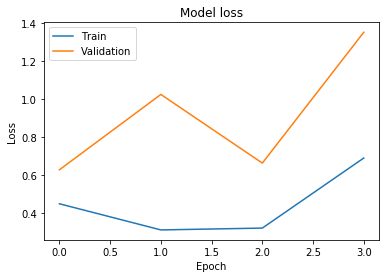

Overfit checks:
Model Accuracy: 0.8813760280609131
---------------- Round #8 ----------------
Model Accuracy: 0.8066298365592957


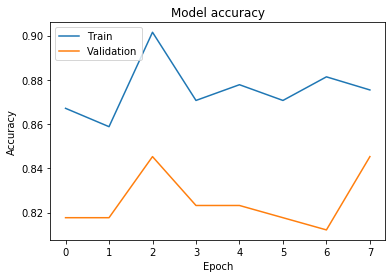

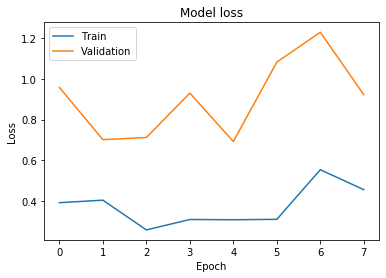

Overfit checks:
Model Accuracy: 0.8884934782981873
---------------- Round #9 ----------------
Model Accuracy: 0.8287292718887329


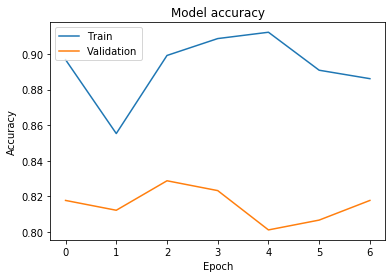

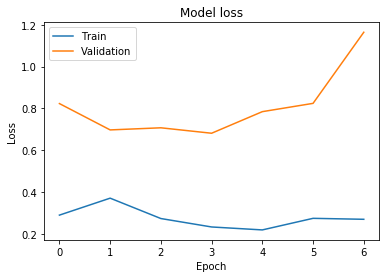

Overfit checks:
Model Accuracy: 0.9217081665992737


In [26]:
frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_meaningful_subset(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

for i in range(0,10):
    print("---------------- Round #{} ----------------".format(i))

    history = model.fit(x_train, y_train, epochs=1000, verbose=0,
              validation_data=(x_validate, y_validate), callbacks=[early_stopping_monitor])
    silent_evaluation(model, x_test, y_test)
    plot_graphs(history)
    print("Overfit checks:")
    silent_evaluation(model, x_train, y_train)

## Misc.

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(843, 10)
Model Accuracy: 0.9226519465446472


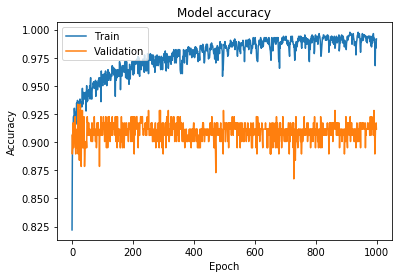

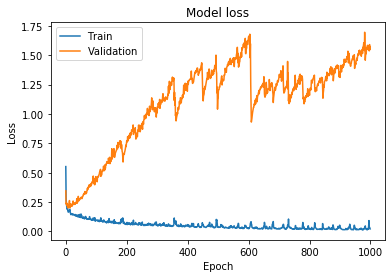

Overfit checks:
Model Accuracy: 0.9952550530433655


In [30]:
frame = load_frame()
frame = load_quartile(frame)
data_x, data_y, number_of_features = load_meaningful_subset_2(frame)
x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(500, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

#for i in range(1,1):
#print("---------------- Round #{} ----------------".format(i))

history = model.fit(x_train, y_train, epochs=1000, verbose=0,
          validation_data=(x_validate, y_validate))#, callbacks=[early_stopping_monitor])
silent_evaluation(model, x_test, y_test)
plot_graphs(history)
print("Overfit checks:")
silent_evaluation(model, x_train, y_train)